In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision import transforms
from ipywidgets import interact, IntSlider, fixed
from IPython.display import display
from PIL import Image
from skimage.transform import resize
from keras.preprocessing import image
# Assuming utils, evaluation, and explanations modules are custom and present in your project
from utils import *
from evaluation import CausalMetric, auc, gkern
from explanations import RISE
import shap 
cudnn.benchmark = True
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import json
import torch
from torchvision.models import resnet50
from torch.nn.functional import softmax
from PIL import Image
from torchvision import transforms
from morphology import *

In [2]:
# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.cuda()

for p in model.parameters():
    p.requires_grad = False

model = nn.DataParallel(model)

c:\Users\eagua\anaconda3\envs\torch_cuda\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\eagua\anaconda3\envs\torch_cuda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
import tensorflow as tf

# getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
    
img_path = 'goldfish.jpg'
img = read_tensor(img_path)

def predict_with_resnet50_pytorch(image_tensor, target_class=1):
    # Ensure the model is in evaluation mode
    model = resnet50(pretrained=True)
    model = model.eval()
    
    # Ensure the tensor is in the correct shape [C, H, W] with C=3, H=W=224
    # Check for batch dimension and add if missing
    if image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0)
    
    # Perform prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)
        percentage = probabilities[0][target_class].item() * 100
        top_probabilities, top_classes = torch.topk(probabilities, k=3)
    # Convert output probabilities to softmax probabilities
    
    # Decode predictions to find the top 3 predictions
    return f'Prediction for class {target_class} = {percentage:.2f}%', top_probabilities[0], top_classes[0]

predicted_classes, top_probabilities, top_classes = predict_with_resnet50_pytorch(img)

# Assuming get_class_name is a function to get class names from class indices
# You'll need to define or import this function
print(predicted_classes)
for i in range(len(top_classes)):
    class_name = get_class_name(top_classes[i].item())
    percentage = top_probabilities[i].item() * 100
    print(f'Top {i+1} class: {class_name}, Probability: {percentage:.2f}%')
    
print(predicted_classes)
get_class_name(top_classes[0].item())
target_class = top_classes[0].item()

c:\Users\eagua\anaconda3\envs\torch_cuda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


Prediction for class 1 = 95.19%
Top 1 class: goldfish, Probability: 95.19%
Top 2 class: paintbrush, Probability: 1.32%
Top 3 class: bubble, Probability: 0.70%
Prediction for class 1 = 95.19%


In [4]:
'''
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
from skimage.transform import resize
from torchvision.models import resnet50

class RISE:
    def __init__(self, model, input_size):
        self.model = model
        self.input_size = input_size

    def generate_masks(self, N, s, p1):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        self.masks = np.empty((N, *self.input_size))

        for i in tqdm(range(N), desc='Generating filters'):
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = N
        self.p1 = p1
        print(self.masks.shape)

    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = self.masks.shape[0]

    def generate_mutants(self, img_tensor, N, s, p1, target_class):
        img_tensor = img_tensor.cuda()
        self.model.eval()
        
        with torch.no_grad():
            output = self.model(img_tensor)  # Add batch dimension
            probabilities = F.softmax(output, dim=1)
            max_pred_score = probabilities[0][target_class].item() * 100

        threshold = max_pred_score / 2
        print(f'Maximum prediction score: {max_pred_score}')
        print(f'Threshold: {threshold}')

        sampled_tensor = torch.empty((N, *img_tensor.shape), device=img_tensor.device)
        scores = torch.empty(N, device=img_tensor.device)
        pass_count = 0
        fail_count = 0
        self.generate_masks(N, s, p1)
        dilation = Dilation2d(1, 1, kernel_size=3, soft_max=False, beta=5).to(img_tensor.device)
        erosion = Erosion2d(1, 1, kernel_size=3, soft_max=False, beta=5).to(img_tensor.device)
        for i in range(N): 
            #is_pass = (i % 2 == 0 and pass_count < N // 2) or (i % 2 != 0 and fail_count >= N // 2)
            
            if i % 2 == 0:
                target_score = threshold
                tag = "Pass"
                kernel_size = 3
                print(f"Generating Mutant Number#{i+1}/ It should be Pass{N}")

            else:
                target_score = threshold
                tag = "Fail"
                #pass_count += 1
                kernel_size = 3
                print(f"Generating Fail Mutant #{i+1}/{N} It should be a Fail")

            found = False
            #mask = self.masks[i]
            while not found:
                #print(self.masks.shape)


                masked_image = torch.mul(self.masks[i], img_tensor) # Add batch dimension
                print(masked_image.shape)  # Add batch dimension
                with torch.no_grad():
                    output = self.model(masked_image)
                    probabilities = F.softmax(output, dim=1)
                    pred_score = probabilities[:, target_class].max().item() * 100

                if (tag == "Pass" and pred_score >= target_score) or (tag == "Fail" and pred_score < target_score):
                    found = True
                    print(f"Mutant #{i+1} found with score: {pred_score:.2f}")
                    best_score = pred_score
                    best_mutant = masked_image
                else:
                    if tag == "Pass" and pred_score <= target_score:
                        print(f"mask before dilation: {self.masks[i].shape}")
                        self.masks = dilation(self.masks[i])
                        print(f"mask before after: {self.masks[i].shape}")
                        kernel_size += 3
                        print(f"Kernel size: {kernel_size}, Pred score: {pred_score}, Dilation!")

                    elif tag == "Fail" and pred_score >= target_score:
                        self.masks = erosion(self.masks[i])
                        print(f"Kernel size: {kernel_size}, Pred score: {pred_score}, Erosion!")
                        kernel_size += 3
                    
            sampled_tensor[i] = best_mutant.squeeze(0)  # Remove the batch dimension
            scores[i] = best_score
        
        return sampled_tensor, scores.cpu().tolist()

def get_class_name(class_idx):
    labels = np.loadtxt('synset_words.txt', str, delimiter='\t')
    print(f"Class index: {class_idx}")
    print(f"Total classes: {len(labels)}")
    return ' '.join(labels[class_idx].split(',')[0].split()[1:])

# Usage example
model = resnet50(pretrained=True).cuda()
explainer = RISE(model, (224, 224))

sampled_tensor, scores = explainer.generate_mutants(img, N=4, s=8, p1=0.2, target_class=target_class)
'''

'\nimport numpy as np\nimport torch\nimport torch.nn.functional as F\nfrom tqdm import tqdm\nfrom skimage.transform import resize\nfrom torchvision.models import resnet50\n\nclass RISE:\n    def __init__(self, model, input_size):\n        self.model = model\n        self.input_size = input_size\n\n    def generate_masks(self, N, s, p1):\n        cell_size = np.ceil(np.array(self.input_size) / s)\n        up_size = (s + 1) * cell_size\n\n        grid = np.random.rand(N, s, s) < p1\n        grid = grid.astype(\'float32\')\n\n        self.masks = np.empty((N, *self.input_size))\n\n        for i in tqdm(range(N), desc=\'Generating filters\'):\n            x = np.random.randint(0, cell_size[0])\n            y = np.random.randint(0, cell_size[1])\n            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode=\'reflect\',\n                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]\n        self.masks = self.masks.reshape(-1, 1,

Buenardo

In [5]:
#BUENAZO
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
from skimage.transform import resize
from torchvision.models import resnet50
from torch.nn import Module

class RISE:
    def __init__(self, model, input_size):
        self.model = model
        self.input_size = input_size

    def generate_masks(self, N, s, p1):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        self.masks = np.empty((N, *self.input_size))

        for i in tqdm(range(N), desc='Generating filters'):
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = N
        self.p1 = p1
        print(self.masks.shape)

    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = self.masks.shape[0]

    def generate_mutants(self, img_tensor, N, s, p1, target_class):
        img_tensor = img_tensor.cuda()
        self.model.eval()
        
        with torch.no_grad():
            output = self.model(img_tensor)
            probabilities = F.softmax(output, dim=1)
            max_pred_score = probabilities[0][target_class].item() * 100

        threshold = max_pred_score / 2
        print(f'Maximum prediction score: {max_pred_score}')
        print(f'Threshold: {threshold}')

        sampled_tensor = torch.empty((N, *img_tensor.shape), device=img_tensor.device)
        scores = torch.empty(N, device=img_tensor.device)
        pass_count = 0
        fail_count = 0
        self.generate_masks(N, s, p1)

        dilation = Dilation2d(1, 1, kernel_size=3, soft_max=False, beta=5).to(img_tensor.device)
        erosion = Erosion2d(1, 1, kernel_size=3, soft_max=False, beta=5).to(img_tensor.device)

        for i in range(N):
            if i % 2 == 0:
                target_score = threshold
                tag = "Pass"
                print(f"Generating Mutant Number#{i+1}/ It should be Pass {N}")
            else:
                target_score = threshold
                tag = "Fail"
                print(f"Generating Fail Mutant #{i+1}/{N} It should be a Fail")

            found = False
            mask = self.masks[i].clone()  # Clone the mask to prevent in-place modifications
            kernel_size = 3
            while not found:
                masked_image = torch.mul(mask, img_tensor)
                with torch.no_grad():
                    output = self.model(masked_image)
                    probabilities = F.softmax(output, dim=1)
                    pred_score = probabilities[:, target_class].max().item() * 100

                if (tag == "Pass" and pred_score >= target_score) or (tag == "Fail" and pred_score < target_score):
                    found = True
                    print(f"Mutant #{i+1} found with score: {pred_score:.2f}")
                    best_score = pred_score
                    best_mutant = masked_image
                    sampled_tensor[i] = best_mutant[-1].squeeze(0)
                    scores[i] = best_score
                    self.masks[i] = mask[-1]
                else:
                    if tag == "Pass" and pred_score <= target_score:
                        mask = dilation(mask)  # Apply dilation to the cloned mask
                        print(f"Kernel size: {dilation.kernel_size}, Pred score: {pred_score}, Dilation!")
                        kernel_size += 3
                    else:
                        mask = erosion(mask)  # Apply erosion to the cloned mask
                        print(f"Kernel size: {erosion.kernel_size}, Pred score: {pred_score}, Erosion!")
                        kernel_size += 3
            print(best_mutant.shape)
    
        return sampled_tensor, scores.cpu().tolist()

def get_class_name(class_idx):
    labels = np.loadtxt('synset_words.txt', str, delimiter='\t')
    print(f"Class index: {class_idx}")
    print(f"Total classes: {len(labels)}")
    return ' '.join(labels[class_idx].split(',')[0].split()[1:])

# Usage example
model = resnet50(pretrained=True).cuda()
explainer = RISE(model, (224, 224))
N = 200
# Assuming img and target_class are defined
sampled_tensor, scores = explainer.generate_mutants(img, N, s=5, p1=0.4, target_class=target_class)

Maximum prediction score: 95.1691746711731
Threshold: 47.58458733558655


Generating filters: 100%|██████████| 200/200 [00:00<00:00, 831.57it/s]


torch.Size([200, 1, 224, 224])
Generating Mutant Number#1/ It should be Pass 200
Mutant #1 found with score: 75.68
torch.Size([1, 3, 224, 224])
Generating Fail Mutant #2/200 It should be a Fail
Mutant #2 found with score: 21.42
torch.Size([1, 3, 224, 224])
Generating Mutant Number#3/ It should be Pass 200
Mutant #3 found with score: 79.89
torch.Size([1, 3, 224, 224])
Generating Fail Mutant #4/200 It should be a Fail
Kernel size: 3, Pred score: 97.94723987579346, Erosion!
Kernel size: 3, Pred score: 99.19227957725525, Erosion!
Kernel size: 3, Pred score: 99.31085109710693, Erosion!
Kernel size: 3, Pred score: 99.21889305114746, Erosion!
Kernel size: 3, Pred score: 99.02549386024475, Erosion!
Kernel size: 3, Pred score: 98.67491126060486, Erosion!
Kernel size: 3, Pred score: 98.50766062736511, Erosion!
Kernel size: 3, Pred score: 98.56615662574768, Erosion!
Kernel size: 3, Pred score: 98.91201257705688, Erosion!
Kernel size: 3, Pred score: 98.67221117019653, Erosion!
Kernel size: 3, Pred

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, fixed
import torch  # Assuming the mutants tensor is a PyTorch tensor

def visualize_single_mutant(mutants, scores, index):
    """
    Visualize a single mutant image with its score.
    
    Parameters:
    - mutants: Tensor of mutant images.
    - scores: List or array of scores corresponding to the mutant images.
    - index: Index of the mutant image to visualize.
    """
    mutant_image = mutants[index].detach().squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Squeeze and permute dimensions
    plt.figure(figsize=(5, 5))
    plt.imshow(mutant_image)
    plt.title(f"Mutant {index+1}\n{scores[index]:.2f}%")
    plt.axis('off')
    plt.show()

# Example tensor and scores (replace these with your actual data)
num_mutants = sampled_tensor.shape[0]
interact(visualize_single_mutant, 
         mutants=fixed(sampled_tensor), 
         scores=fixed(scores), 
         index=IntSlider(min=0, max=num_mutants-1, step=1, description='Mutant Index:'));

interactive(children=(IntSlider(value=0, description='Mutant Index:', max=199), Output()), _dom_classes=('widg…

In [7]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
def unnormalize(tensor, mean, std):
    """
    Unnormalizes a tensor using the specified mean and std.
    """
    mean = torch.tensor(mean, device=tensor.device).view(1, 3, 1, 1)
    std = torch.tensor(std, device=tensor.device).view(1, 3, 1, 1)
    tensor = tensor * std + mean
    return tensor.clamp(0, 1)

def rgb_to_grayscale(tensor):
    """
    Converts RGB images to grayscale by applying the standard luminosity method.
    """
    r, g, b = tensor[:, 0, :, :], tensor[:, 1, :, :], tensor[:, 2, :, :]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return grayscale.unsqueeze(1)  # Maintain the batch and channel dimension

mean = [0.485, 0.456, 0.406]  # ImageNet mean
std = [0.229, 0.224, 0.225]   # ImageNet std
sampled_tensor = unnormalize(sampled_tensor, mean, std)
sampled_tensor = TF.rgb_to_grayscale(sampled_tensor)


# Example tensor and scores (replace these with your actual data)
num_mutants = sampled_tensor.shape[0]
interact(visualize_single_mutant, 
         mutants=fixed(sampled_tensor), 
         scores=fixed(scores), 
         index=IntSlider(min=0, max=num_mutants-1, step=1, description='Mutant Index:'));

sampled_tensor.shape

interactive(children=(IntSlider(value=0, description='Mutant Index:', max=199), Output()), _dom_classes=('widg…

torch.Size([200, 1, 1, 224, 224])

In [19]:
def calculate_relevance_scores(sampled_tensor, N, scores, threshold, device='cuda'):

    # Move tensor to device
    sampled_tensor = torch.squeeze(sampled_tensor, dim=1)
    sampled_tensor = sampled_tensor.to(device)
    
    scores = torch.tensor(scores, device=device)
    # Determine the dimensions of the images
    _, C, H, W = sampled_tensor.shape
    
    # Initialize the counters for each pixel
    Ep = torch.zeros((H, W), dtype=torch.float, device=device)
    Np = torch.zeros((H, W), dtype=torch.float, device=device)
    Ef = torch.zeros((H, W), dtype=torch.float, device=device)
    Nf = torch.zeros((H, W), dtype=torch.float, device=device)
    
    # Calculate the masks for the conditions
    executed_mask = sampled_tensor.sum(dim=1) != 0  # Pixel executed if any channel is non-zero
    passed_mask = scores > threshold  # Prediction passed
    failed_mask = scores <= threshold  # Prediction failed

    # Iterate over each batch of the tensor
    for i in range(sampled_tensor.shape[0]):
        current_image = sampled_tensor[i].squeeze()       # Shape: [224, 224]
        current_executed_mask = executed_mask[i]          # Shape: [224, 224]
        current_mask = explainer.masks[i].squeeze()       # Shape: [224, 224]
        
        # Check the score against the threshold
        if scores[i] > threshold:
            Ep += current_image 
        else:
            Ef += current_image 
    

    pixel_indices = [(i, j) for i in range(224) for j in range(224)]
    Ep_values = [Ep[i, j].item() for i, j in pixel_indices]
    Ef_values = [Ef[i, j].item() for i, j in pixel_indices]
            # Debugging print statements
    print(f"Mutant {i}: Score = {scores[i].item()}")
    print(f"Executed Mask Sum = {current_executed_mask.sum().item()}")
    print(f"Current Image Sum = {current_image.sum(dim=0).sum().item()}")
    print(f"Ep Sum = {Ep.sum().item()}")
    print(f"Np Sum = {Np.sum().item()}")
    print(f"Ef Sum = {Ef.sum().item()}")
    print(f"Nf Sum = {Nf.sum().item()}")
    DV = N/2
    Np = DV-Ep
    Nf = DV-Ef
    #Ep = Ep/2
    #Ef = Ef/2
    #Np = N - Ep
    #Nf = N - Ef
    # Calculate the relevance scores
    relevance_scores = torch.zeros((H, W, 4), dtype=torch.float, device=device)
    relevance_scores[:, :, 0] = Ep
    relevance_scores[:, :, 1] = Np
    relevance_scores[:, :, 2] = Ef
    relevance_scores[:, :, 3] = Nf
    
    return relevance_scores

# Extract the second dimension, which contains class labels


relevance_scores = calculate_relevance_scores(sampled_tensor, scores)

print(scores)
print(sampled_tensor.shape)
# Convert relevance_scores to a readable format
relevance_scores_np = relevance_scores.detach().cpu().numpy()

# Flatten the H and W dimensions to make it easier to print
H, W, _ = relevance_scores_np.shape
flattened_scores = relevance_scores_np.reshape(H * W, 4)

# Print the first 1000 pixels
for i in range(min(1000, flattened_scores.shape[0])):
    Ep, Np, Ef, Nf = flattened_scores[i]
    print(f'Pixel {i}: Ep={Ep:.4f}, Np={Np:.4f}, Ef={Ef:.4f}, Nf={Nf:.4f}')


TypeError: calculate_relevance_scores() missing 2 required positional arguments: 'scores' and 'threshold'

In [15]:
def calculate_ochiai(pixel):
    Ep, Np, Ef, Nf = pixel
    return Ef / np.sqrt((Ef + Nf) * (Ef + Ep))

def calculate_tarantula(pixel):
    Ep, Np, Ef, Nf = pixel
    return (Ef/(Ef + Nf)) / ((Ef/(Ef + Nf)) + (Ep/(Ep + Np)))

def calculate_zoltar(pixel):
    Ep, Np, Ef, Nf = pixel
    return Ef/(Ef + Nf + Ep + ((10000*Nf*Ep)/Ef))  

def calculate_wong1(pixel):
    Ep, Np, Ef, Nf = pixel
    return Ef - Ep

ochiai_scores = np.array([calculate_ochiai(pixel) for pixel in flattened_scores])
tarauntula_scores = np.array([calculate_tarantula(pixel) for pixel in flattened_scores])
zoltar_scores = np.array([calculate_zoltar(pixel) for pixel in flattened_scores])
wong1_scores = np.array([calculate_wong1(pixel) for pixel in flattened_scores])

def map_values_to_range(values, target_min=0, target_max=100):
    src_min = values.min()
    src_max = values.max()
    return target_min + (values - src_min) * (target_max - target_min) / (src_max - src_min)

mapped_ochiai_scores = map_values_to_range(ochiai_scores)
mapped_tarauntula_scores = map_values_to_range(tarauntula_scores)
mapped_zoltar_scores = map_values_to_range(zoltar_scores)
mapped_wong1_scores = map_values_to_range(wong1_scores)

# Select 1000 random pixels

random_indices = random.sample(range(len(zoltar_scores)), 1000)
random_ochiai_scores = zoltar_scores[random_indices]

#print(f" Ochiai Score pixel 1: {ochiai_scores[1]}")


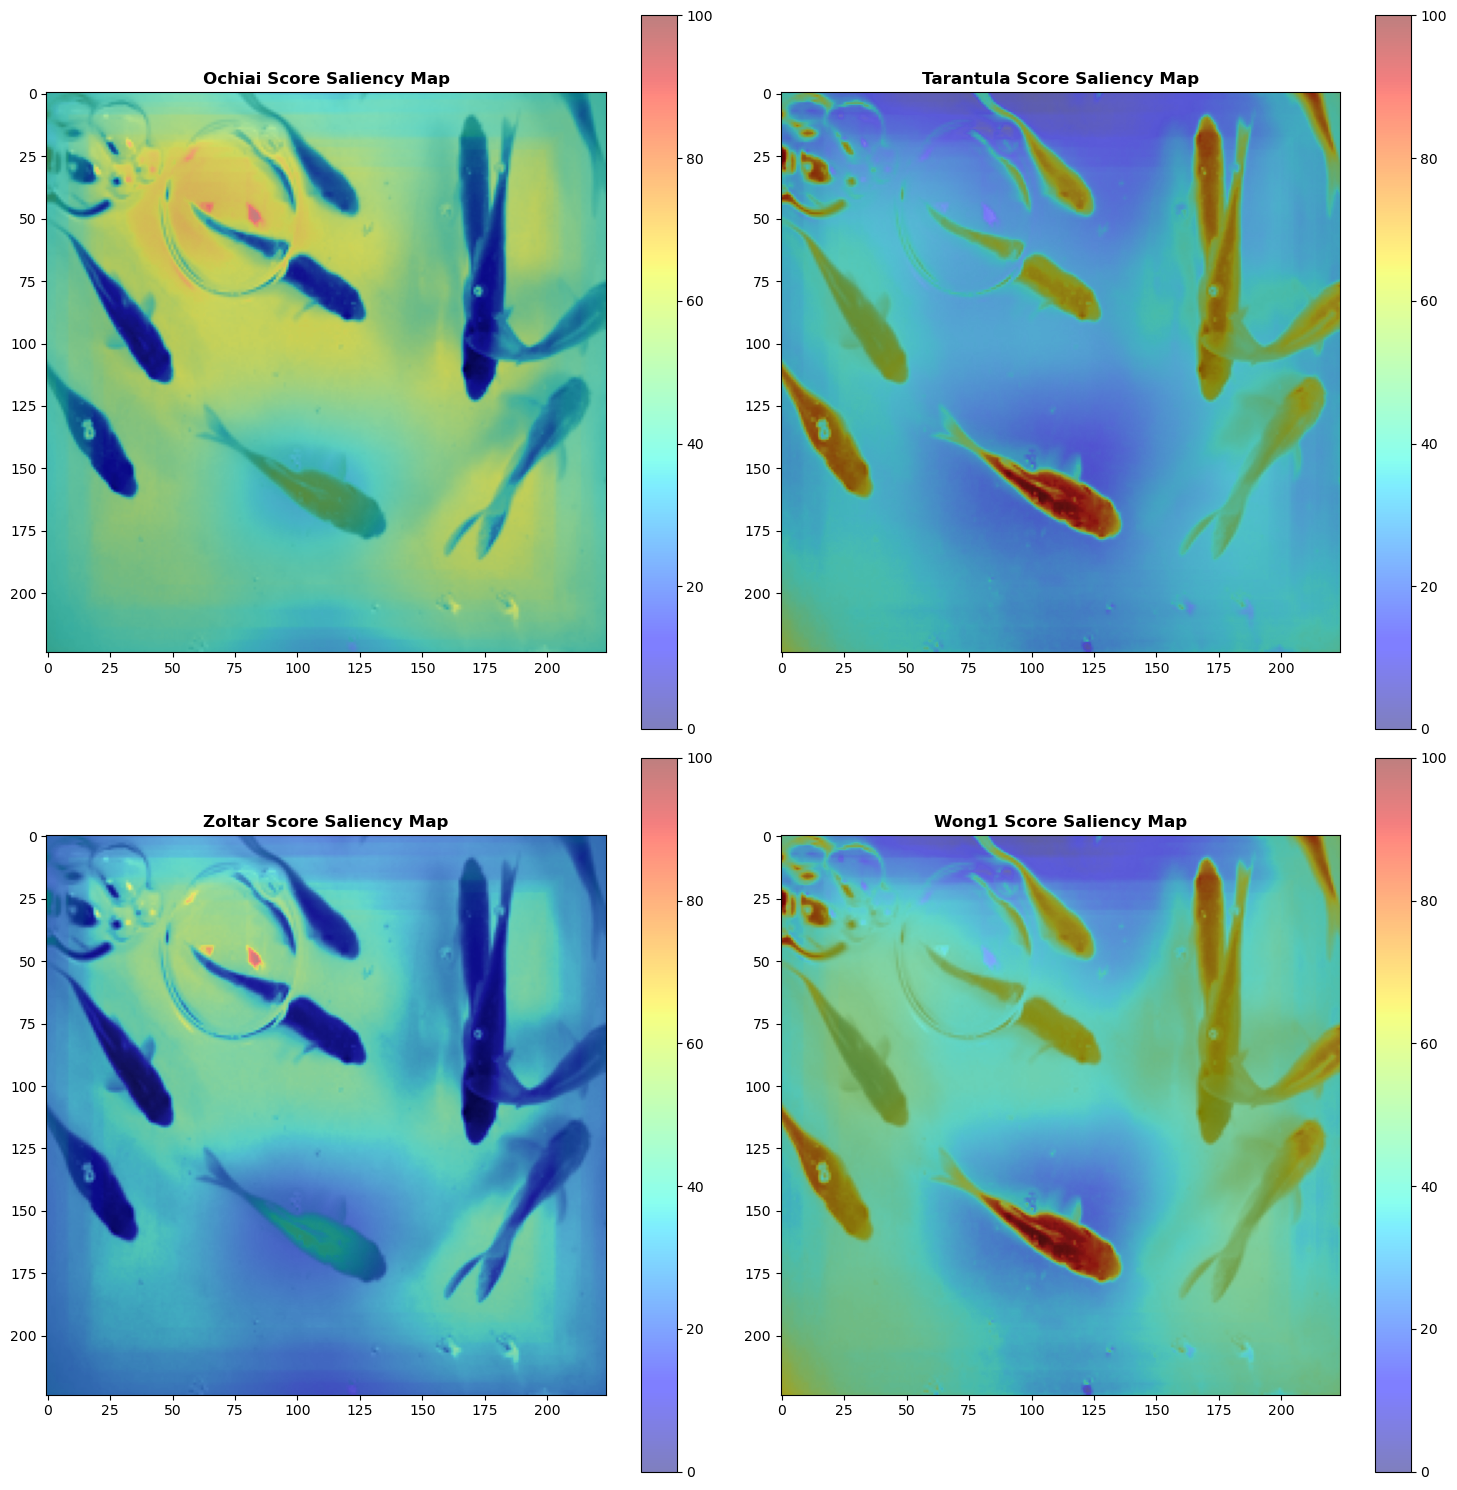

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and resize the original image, and convert to grayscale
original_image = Image.open(img_path).resize((224, 224)).convert('L')  # Replace with your image path
original_image_array = np.array(original_image)

# Prepare the saliency maps
ochiai_map = mapped_ochiai_scores.reshape((224, 224))
tarantula_map = mapped_tarauntula_scores.reshape((224, 224))
zoltar_map = mapped_zoltar_scores.reshape((224, 224))
wong1_map = mapped_wong1_scores.reshape((224, 224))

# Create the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Define the extent
extent = [0, 224, 0, 224]

# List of maps and titles
maps = [ochiai_map, tarantula_map, zoltar_map, wong1_map]
titles = ['Ochiai Score Saliency Map', 'Tarantula Score Saliency Map', 'Zoltar Score Saliency Map', 'Wong1 Score Saliency Map']

# Plot each map
for ax, saliency_map, title in zip(axs.ravel(), maps, titles):
    # Display the original image
    ax.imshow(original_image_array, cmap='gray')
    
    # Overlay the saliency map
    c = ax.imshow(saliency_map, cmap='jet', alpha=0.5)
    
    # Add a colorbar
    fig.colorbar(c, ax=ax)
    
    # Add title
    ax.set_title(title, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

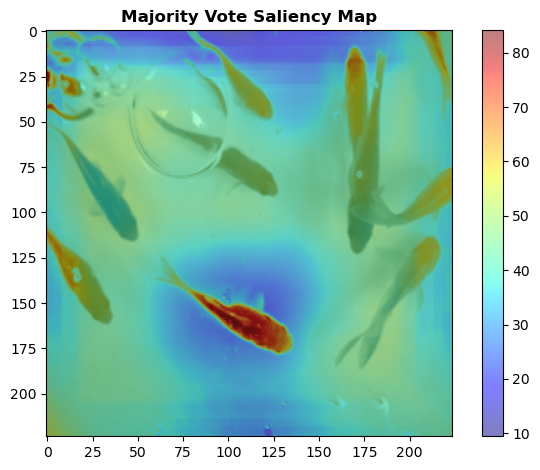

In [17]:

# Stack the scores for majority voting
all_scores = np.vstack((mapped_ochiai_scores, mapped_tarauntula_scores, mapped_wong1_scores)).T

# Function to get majority vote
def majority_vote(scores):
    return np.average(scores)# Apply majority voting

majority_scores = np.apply_along_axis(majority_vote, 1, all_scores)

# Apply majority voting
majority_scores = np.apply_along_axis(majority_vote, 1, all_scores)


# Reshape the majority scores to match the original image dimensions
saliency_map = majority_scores.reshape(original_image_array.shape)

# Plot the majority vote saliency map
fig, ax = plt.subplots()

# Display the original image
ax.imshow(original_image_array, cmap='gray')

# Overlay the saliency map
c = ax.imshow(saliency_map, cmap='jet', alpha=0.5)

# Add a colorbar
fig.colorbar(c, ax=ax)

# Add title
ax.set_title('Majority Vote Saliency Map', fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

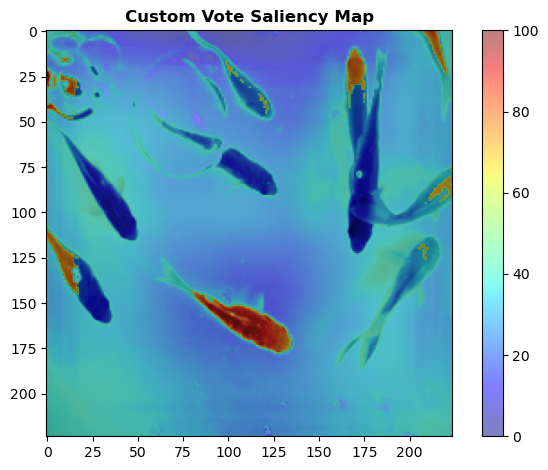

In [18]:
# Function to perform the custom voting logic
def custom_voting(scores):
    ochiai, tarantula, wong1 = scores
    
    # Prioritize low Ochiai values (below 25) if they are close to Zoltar
    if ochiai < 25:  # adjust the threshold as needed
            return ochiai
    
    # Prioritize high Tarantula and Wong values (80-100)
    if tarantula >= 65 and wong1 >= 60:
        return max(tarantula, wong1)
    
    # Default to the majority voting logic
    values, counts = np.unique(scores, return_counts=True)
    max_count = np.max(counts)
    if np.sum(counts == max_count) == 1:
        return values[np.argmax(counts)]
    else:
        return np.min(scores)

# Apply the custom voting to each pixel
custom_scores = np.apply_along_axis(custom_voting, 1, all_scores)

# Load and resize the original image, and convert to grayscale
 # Replace with your image path
original_image = Image.open(img_path).resize((224, 224)).convert('L')
original_image_array = np.array(original_image)

# Ensure the custom_scores array has the correct size
if custom_scores.size != original_image_array.size:
    raise ValueError(f"Size of custom_scores ({custom_scores.size}) does not match the original image size ({original_image_array.size})")

# Reshape the custom scores to match the original image dimensions
saliency_map = custom_scores.reshape(original_image_array.shape)

# Plot the custom vote saliency map
fig, ax = plt.subplots()

# Display the original image
ax.imshow(original_image_array, cmap='gray')

# Overlay the saliency map
c = ax.imshow(saliency_map, cmap='jet', alpha=0.5)

# Add a colorbar
fig.colorbar(c, ax=ax)

# Add title
ax.set_title('Custom Vote Saliency Map', fontweight='bold')

# Show the plot
plt.tight_layout()